## 파이썬을 이용한 딥러닝 - 기말 개인 프로젝트 과제
### 이름 : 이은희       학번 : 2020120109

---
 현대 딥러닝 기술들은 대체로 굉장히 복잡하며 (아주 많은 Hyperparameter의 수) 높은 예측력을 갖도록 설계되어있다.

딥러닝 모형은 그 자체로 많은 장점을 가지고 있지만, 크게 2가지 단점을 가지고 있다. 

> 1. Black Box :
>               딥러닝 모형의 의사결정 과정은 설계자 또한 알 수가 없다.
> 2. Expensive :
>               딥러닝 모형은 많은 층 (Layer)와 Hyperparameter들로 구성되어있기 때문에 
>               아주 많은 연산량을 요구한다.

딥러닝, 머신러닝 기술의 발전으로 대개의 모형들이 높은 정확도를 보이게 된 현재 시점에서, 많은 딥러닝 모형들은 black box를 투명화 하기 위한 방향으로 더 발전 해 나아가고 있다. 

본 과제에서는 Black box 모형을 투명화 할 수 있는 하나의 방법으로 'Bayesian Optimizer'를 소개하고 MNIST 데이터에 적용해 보려고 한다.

'Bayesian Optimizer'는 모형의 Hyper parameter를 추정하는 과정에 적용되는 방법이다.

일반적으로 모형의 Hyper parameter 추정에는 Grid search 나 randomized serach가 사용되지만,
Grid search는 Hyper parameter가 아주 많은 딥러닝 모형에 사용하기엔 적합하지 않고,
Random search는 확률적 탐색과정으로 Grid search보다 더 빠르고 일반적으로 좋은 결과를 반환하지만, 이전 step 까지의 parameter set의 결과를 전혀 반영하지 않고 다음 후보 parameter set을 고르게 된다.

**'Bayesian Optimzier'** 는 random search 와 마찬가지로 parameter 후보군을 확률적으로 고르게 되지만, **이전 parameter set의 결과를 반영하여 다음 후보군을 추천해 준다는 점이 random search와의 차이점이다.**

더 자세한 작동 과정은 아래에서 설명하도록 하겠다.



---

가장 쉬운 예제 데이터인 MNIST와 CNN의 모형을 사용하여 Bayesian optimizer를 적용해보았다. 






In [1]:
!pip install Bayesian-Optimization

In [1]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from tensorflow.keras import constraints


import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import os
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score #얘는 그냥 cv score만 반환
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from bayes_opt import BayesianOptimization
import tensorflow.keras.backend as K

# MNIST Dataset 을 가져오기
from tensorflow.keras.datasets import mnist

## MNIST data 불러오기

keras library로 부터 데이터를 불러오고, cnn을 적용하기 위한 처리를 진행.
1. label <- one - hot encoding
2. Reshape data and scalling into [0,1] # Keras 모형은 input이 0~1사이일 때 가장 잘 작동.
3. K-fold CV을 사용하기 위해 folder를 생성함
   -> MNIST는 classification problem임으로, 어떤 폴더에 특정 라벨들이 과다 배정되는 것을 막기 위해, Stratified K- Fold 함수를 사용함.

In [33]:
# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 먼저 CV folder를 생성.
e_tr=LabelEncoder()
Y_train_i=e_tr.fit_transform(y_train)

e_te=LabelEncoder()
Y_test_i=e_te.fit_transform(y_test)

skf=StratifiedKFold(n_splits=5,random_state=2021,shuffle=True) # k=5

# 1. Label One-Hot Encoding 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 2. Reshape data and scalling
x_train = x_train.reshape(60000, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(10000, 28, 28, 1).astype('float32') / 255.0


+ 개인 컴퓨터의 사양이 좋지 못한 관계로, Train과 Test data set의 사이즈를 각각 $\frac{1}{10}$로 줄여서 사용하였습니다.

+ 데이터는 계층적 랜덤 추출을 사용해, 각 그룹들이 같은 비율로 추출되도록 하였습니다.

$\therefore$ N.train = 6,000  N.test = 1,000

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit

split=StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=2021)

#train_index= split.split(x_train,Y_train_i)

for train_index, test_index in split.split(x_train,Y_train_i) :
    x_train=x_train[test_index];y_train=y_train[test_index];Y_train_i=Y_train_i[test_index]

unique_train, counts_train = np.unique(Y_train_i, return_counts = True) 
uniq_train = dict(zip(unique_train, counts_train))

for train_index, test_index in split.split(x_test,Y_test_i):
    x_test=x_test[test_index];y_test=y_test[test_index];Y_test_i=Y_test_i[test_index]
    
unique_test, counts_test = np.unique(Y_test_i, return_counts = True) 
uniq_test = dict(zip(unique_test, counts_test))


print(uniq_train)
print(uniq_test)

{0: 592, 1: 674, 2: 596, 3: 613, 4: 584, 5: 542, 6: 592, 7: 627, 8: 585, 9: 595}
{0: 98, 1: 114, 2: 103, 3: 101, 4: 98, 5: 89, 6: 96, 7: 103, 8: 97, 9: 101}


Bayesian Optimizer를 적용하기 전에 먼저 모형을 정의한다.

In [57]:
def my_model(n_conv_layers,n_fully_connected_layers,n_cmaps,n_node,dr,ks,ps,lr):
        #Activation function  : relu
    act_fn='relu'
    
    model=Sequential()
    model.add(Conv2D(int(n_cmaps),kernel_size=int(ks),input_shape=(28,28,1),activation=act_fn
                                 ,padding='same'))
    model.add(MaxPooling2D(pool_size=int(ps),padding='same'))
    model.add(Dropout(dr))
            
    for index , layer in enumerate(np.arange(int(n_conv_layers))): # Convolution Layer 개수 만큼 층을 쌓는 부분
        model.add(Conv2D(int(n_cmaps),kernel_size=int(ks),activation=act_fn
                                 ,padding='same'))
        model.add(MaxPooling2D(pool_size=int(ps),padding='same'))
        model.add(Dropout(dr))
            
    model.add(Flatten())

    for index , layer in enumerate(np.arange(int(n_fully_connected_layers))): # Flatten layer 개수 만큼 층을 쌓는 부분.
        model.add(Dense(int(n_node),activation=act_fn))
        model.add(Dropout(dr))

    model.add(Dense(10,activation="softmax"))
    
    optimizer=optimizers.Adam(learning_rate=lr) # Optimizer : Adam 
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,
                 metrics=['accuracy'])
    
    return model

In [68]:
def my_function(n_conv_layers,n_fully_connected_layers,n_cmaps,n_node,dr,ks,ps,lr,epoch):
    model=my_model(n_conv_layers,n_fully_connected_layers,n_cmaps,n_node,dr,ks,ps,lr)
    
    scores=np.zeros(5)
    for i, (idx_train,idx_test) in enumerate(skf.split(x_train,Y_train_i)):
        X_train_k=x_train[idx_train]
        Y_train_k=y_train[idx_train]
        X_test_k=x_train[idx_test]
        Y_test_k=Y_train_i[idx_test]

        model.fit(X_train_k,Y_train_k,epochs=int(epoch),verbose=0)
        Yhat=np.argmax(model.predict(X_test_k), axis=-1)

        acc_k=np.mean(Yhat==Y_test_k) #accuracy for k-th folder

        scores[i]=acc_k
        
    ave_score=np.mean(scores)
    
    return ave_score

#### Bayesian Optimaizer를 통해 추정 할 하이퍼 파라미터 리스트.
1. n_conv_layers : Convolution Layer의 수
2. n_fully_connected_layers : Fully connected Layer의 수
3. n_cmaps : Convolution layer 의 노드 수 
4. n_node : Fully connected Layer의 노드 수
5. dr : Convolution layer part에서 dropout rate.
6. ps : Convolution layer part에서 polling size
7. lr : Learning rate
8. epoch

+ Bayesian Optimizer 같은 경우는 numerical parameter에 대해서만 작동하므로, 
Activation function 과 같은 character parameter는 가장 일반적인 것으로 사용하였음.
-> Activation function : relu
-> Optimizer : Adam
-> Polling method : Max Pooling
-> Loss : Categorical Cross Entropy



## What is 'Bayesian Optimizer' ?

 Bayesian Optimization (이하 '베이지안 최적화') 이란 어느 입력 값 x를 받는 미지의 목적함수 $f$ 를 상정하여 그 함수 값 $f(x)$를 최대로 하는 최적해를 찾는 방법이다. 이 방법에는 2가지의 필수 요소가 존재하는데, 첫번째는 Surrogate Model이고, 다른 하나는 Acquisition Fuction이다.

 > **Surrogate Model** 이란 미지의 목적 함수 $f(x)$에 대한 확률 추정 과정을 수행하는 모델이다. 쉽게 말해, 베이지안 통계 분석에서 쓰이는 Prior distribution 과 같은 역할을 한다고 볼 수 있다. 본 과제에서는 가장 일반적으로 많이 사용되는 GP(Gaussian Process)를 Surrogate Model로 사용하였다.

 > **Acquisition Function** 이란 Surrogate Model의 확률 분포하에서 해당 시점의 확률 분포 ($t$시점까지 계산된 확률 분포)에서 지금 까지 나온 값들보다 더 큰 값이 나올 가능성이 높은 point를 알려주는 함수 이다. 본 과제에서는 EI (Expected Imporvement) 를 Acquisition function으로 사용하였다.
>
>EI function에 대해 더 자세히 언급해보자면,
>
> 다음 후보 점을 찾기 위해서는 크게 2가지 전략(Exploration 과 Expectation)이 존재한다. Exploration은 불확실성이 가장 높은 곳에서 지금 까지 나온 값들보다 더 좋은 포인트가 있을 것이다 라는 전략이고, Expectation은 지금까지 나온 포인트들 중 높은 값들 근처에 더 높은 포인트가 있을 것이라는 전략이다.
>
> 이 두 가지의 전략에서 적절하게 균형 잡힌 포인트를 얻을 수 있도록 설계된 Acqusition function이 바로 Expected Improvement Acqusition function이다. 수식적인 표현은 아래 그림과 같다.


 ![AC.JPG](https://drive.google.com/uc?id=1kaU4uuAkq7PGs-_0NRuGeFax3MCageyr)


> **베이지안 최적화의 작동 과정**

![BOworking.png](https://drive.google.com/uc?id=1tnltlgArggXkRvB5BLShO8tONyYRVH25)

검은색 점선 : Target function
검은색 실선 : Surrogate Model
파란색 음영 : Confidence Interval
하단부 초록색 실선 : Acquisition Function

검은색 점 : 관측된 점

시점 $t$ 를 반복 되면서, Surrogate Model의 불확실성 (파란색 음영) 이 점점 줄어들고, Surrogate Model이 Target function에 근사해지며, 매 시점 $t$에서 다음 입력 값 후보는 Acqusition function을 최대화 하는 점으로 추천 된다.

베이지안 최적화는 확률 과정이라는 점에서 Random Search와 유사하지만, 이전 후보 입력 값들의 결과를 반영하여 다음 입력 값이 추천된다는 점에서 Random Search보다 더 근거 있는 하이퍼-파라미터 조합을 얻을 수 있다는 장점이 있다.




In [70]:
# Hyper parameter 별 범위 설정
## 파라미터 별 범위는 실험자가 manual하게 설정.
pbound={
    'n_conv_layers':(1,6),'n_fully_connected_layers':(1,6),
    'n_cmaps':(32,100),'n_node': (32,100),'lr': (0.001,0.01),'dr': (0.01,0.4),
    'ks':(2,5),'ps':(2,5),'epoch':(30,100)}

optimizer=BayesianOptimization(
    f=my_function, # Target 함수
    pbounds=pbound, # Hyper parameter의 집합
    verbose=2,random_state=2021)


optimizer.maximize(init_points=2,n_iter=20,xi=0.01,acq='ei') 
# init_points : random 하게 몇개의 초기값을 잡을 것인지
# n_iter : iteration 횟수, 많을 수록 더 정확한 값을 얻을 수 있다.
# xi : 어느 정도의 강도로 expoloration을 고려할 것인지. (Defalut = 0.00)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

|   iter    |  target   |    dr     |   epoch   |    ks     |    lr     |  n_cmaps  | n_conv... | n_full... |  n_node   |    ps     |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9883   |  0.2463   |  81.34    |  2.417    |  0.003814 |  99.81    |  1.641    |  1.895    |  83.2     |  3.986    |
|  2        |  0.1123   |  0.3159   |  36.78    |  2.176    |  0.009662 |  73.93    |  1.433    |  3.806    |  73.92    |  4.892    |
|  3        |  0.9605   |  0.03836  |  79.71    |  3.55     |  0.007623 |  98.86    |  2.563    |  1.23     |  82.99    |  3.268    |
|  4        |  0.991    |  0.01     |  100.0    |  5.0      |  0.001    |  100.0    |  6.0      |  1.0      |  100.0    |  2.0      |
|  5        |  0.9845   |  0.4      |  100.0    |  2.0      |  0.001    |  100.0    |  1.0      |  1.0      |  32.0     |  5.0      |
|  6        |  0.6615   |  0.01     |  100.0    |  2.0      | 

In [71]:
# 최적화 결과
optimizer.max

{'target': 0.9951666666666666,
 'params': {'dr': 0.4,
  'epoch': 91.78453354631536,
  'ks': 2.0,
  'lr': 0.001,
  'n_cmaps': 100.0,
  'n_conv_layers': 1.0,
  'n_fully_connected_layers': 1.0,
  'n_node': 100.0,
  'ps': 2.0}}

### 베이지안 최적화 결과: CV-Accuracy = 0.9952
+ drop rate : 0.4
+ epoch : 91
+ kernel size : 2
+ Polling size : 2
+ Learning rate : 0.001
+ Convolution layer의 node 수 : 100
+ Convolution Layer의 수 : 1
+ Flatten layer의 node 수 : 100
+ Flatten layer의 수 : 1


In [72]:
# Dictionary 저장
np.save('Optimum.npy',optimizer.max)

In [ ]:
# load 하는 법
# optimum = np.load('Optimum.npy',allow_pickle='TRUE')
# print(optimum)

In [73]:
# 베이지안 최적화로 튜닝된 최종 모형 
Final_model=my_model(1,1,100,100,0.4,2,2,0.001)
Final_model.summary()


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 28, 28, 100)       500       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 14, 14, 100)       0         
_________________________________________________________________
dropout_137 (Dropout)        (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 14, 14, 100)       40100     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 7, 7, 100)         0         
_________________________________________________________________
dropout_138 (Dropout)        (None, 7, 7, 100)         0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 4900)            

In [74]:
# 전체 train data set을 사용하여 모형을 학습.
history = Final_model.fit(x_train,y_train,epochs=91,verbose=1)

Train on 6000 samples
Epoch 1/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.8740 - acc: 0.7105
Epoch 2/91
6000/6000 [==============================] - 15s 2ms/sample - loss: 0.3487 - acc: 0.8887
Epoch 3/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.2458 - acc: 0.9218
Epoch 4/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.1980 - acc: 0.9415
Epoch 5/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.1692 - acc: 0.9470
Epoch 6/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.1453 - acc: 0.9553
Epoch 7/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.1288 - acc: 0.9612
Epoch 8/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.1038 - acc: 0.9648
Epoch 9/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.1060 - acc: 0.9643
Epoch 10/91
6000/6000 [==============================] - 14s 2ms/sample - loss

Epoch 82/91
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.0195 - acc: 0.9930
Epoch 83/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.0152 - acc: 0.9942
Epoch 84/91
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.0250 - acc: 0.9915
Epoch 85/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.0138 - acc: 0.9953
Epoch 86/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.0180 - acc: 0.9935
Epoch 87/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.0217 - acc: 0.9925
Epoch 88/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.0160 - acc: 0.9940
Epoch 89/91
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.0156 - acc: 0.9957
Epoch 90/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.0276 - acc: 0.9915
Epoch 91/91
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.0158 - ac

In [78]:
y_loss=history.history['loss']
y_acc=history.history['acc']

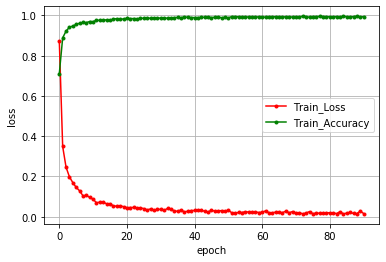

In [79]:
x_len=np.arange(len(y_loss))
plt.plot(x_len,y_loss,marker=".",c="red",label="Train_Loss")
plt.plot(x_len,y_acc,marker=".",c="green",label="Train_Accuracy")

plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [75]:
# Prediction for test data set
y_pred=np.argmax(Final_model.predict(x_test), axis=-1)
# Compute test accuracy
test_acc=np.mean(y_pred==Y_test_i) 

In [76]:
print(test_acc)

0.981


In [80]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred,Y_test_i)

array([[ 98,   0,   1,   0,   0,   0,   1,   0,   1,   0],
       [  0, 114,   1,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0, 101,   1,   0,   0,   0,   1,   0,   1],
       [  0,   0,   0,  99,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,  94,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  87,   1,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,  94,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0, 102,   1,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,  95,   1],
       [  0,   0,   0,   0,   3,   1,   0,   0,   0,  97]], dtype=int64)

## 최종 Test Data set에 대한 Test Accuarcy = 0.981

## 결론

 베이지안 최적화를 통해 적합된 CNN 모형은 Test data set에 대한 Accuracy 가 0.981 아주 좋은 성능을 보였다.
비록 간단한 MNIST 데이터에 대한 결과이지만, 이러한 결과는 베이지안 최적화가 널리 사용되고 있는 Grid search나 randomized search만큼 충분히 모형 튜닝에서 좋은 성능을 보인다는 것을 알 수 있게한다.

다만, 베이지안 최적화는 아직 numerical parameter에 대해서만 작동한다는 단점이 있다.
후에 이러한 단점이 더 보완된다면, 베이지안 최적화는 딥러닝 방법론들을 투명화 하는 하나의 방법으로 널리 사용될 수 있을 것이다.